In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    # actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
histories = []
for i in range(3):    
    l = .5
    step = 200000  # num of interval
    episode_step = step
    a = agent((2,), (2,))
    a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
    a.actor.load_weights('../saved_agent/self_trigger.h5')
    # a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
    # a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
    out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)
    histories.append(out)
    a.actor.save_weights(f'./../saved_agent/self_trigger_05_{i}.h5')







Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 102s 10ms/step - reward: -0.0453
1 episodes - episode_reward: -452.648 [-452.648, -452.648] - loss: 0.001 - mean_absolute_error: 0.023 - mean_q: -0.233

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 119s 12ms/step - reward: -0.0175
1 episodes - episode_reward: -175.378 [-175.378, -175.378] - loss: 0.005 - mean_absolute_error: 0.019 - mean_q: -2.942

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 118s 12ms/step - reward: -0.0303
1 episodes - episode_reward: -303.097 [-303.097, -303.097] - loss: 0.004 - mean_absolute_error: 0.018 - mean_q: -3.340

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 147s 15ms/step - reward: -0.0251
1 episodes - episode_reward: -251.116 [-251.116, -251.116] - loss: 0.003 - mean_absolute_error: 0.015 - mean_q: -3.179

Interval 5 (40000 steps perf

10000/10000 [==============================] - 106s 11ms/step - reward: -3.0730
1 episodes - episode_reward: -30730.139 [-30730.139, -30730.139] - loss: 3.459 - mean_absolute_error: 0.153 - mean_q: -110.631

Interval 12 (110000 steps performed)
10000/10000 [==============================] - 105s 11ms/step - reward: -3.0795
1 episodes - episode_reward: -30795.497 [-30795.497, -30795.497] - loss: 8.150 - mean_absolute_error: 0.186 - mean_q: -129.585

Interval 13 (120000 steps performed)
10000/10000 [==============================] - 104s 10ms/step - reward: -3.0493
1 episodes - episode_reward: -30493.275 [-30493.275, -30493.275] - loss: 9.143 - mean_absolute_error: 0.199 - mean_q: -146.662

Interval 14 (130000 steps performed)
10000/10000 [==============================] - 104s 10ms/step - reward: -3.0632
1 episodes - episode_reward: -30632.080 [-30632.080, -30632.080] - loss: 13.007 - mean_absolute_error: 0.223 - mean_q: -162.438

Interval 15 (140000 steps performed)
10000/10000 [======

20


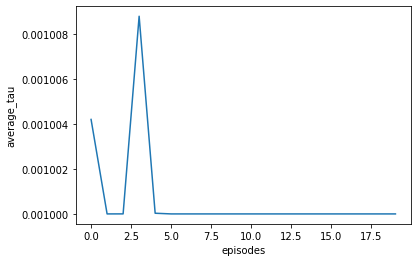

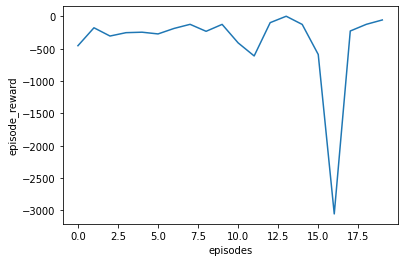

20


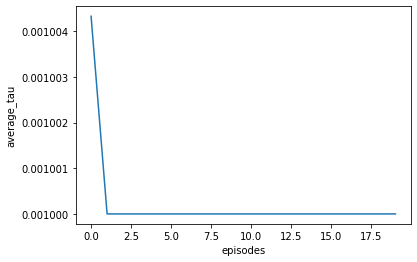

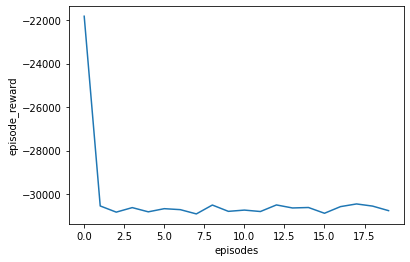

20


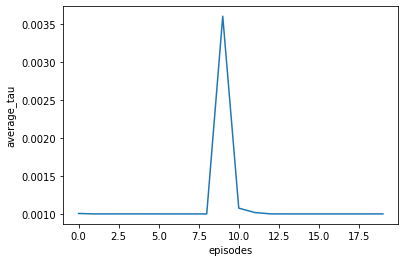

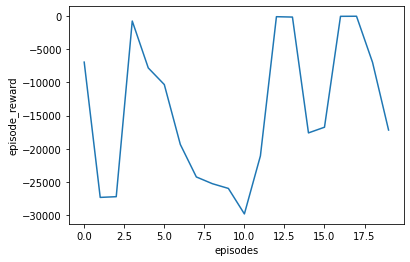

In [6]:
for history in histories:
    his = history.history
    n_episodes = len(his['episode_reward'])
    x_axis = range(n_episodes)
    print(n_episodes)
    plt.plot(x_axis, his['episode_average_tau'])
    plt.xlabel('episodes')
    plt.ylabel('average_tau')
    plt.show()
    plt.plot(x_axis, his['episode_reward'])
    plt.xlabel('episodes')
    plt.ylabel('episode_reward')
    plt.show()

In [7]:
import csv
with open(f'./csv/05.csv', 'w') as f:
    writer = csv.writer(f)
    for history in histories:
        his = history.history
        writer.writerow(his['episode_average_tau'])
        writer.writerow(his['episode_reward'])

In [19]:
#safe learning
histories = []
for i in range(3):    
    l = .5
    step = 200000  # num of interval
    episode_step = step
    a = agent((2,), (2,))
    a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
    a.actor.load_weights('./saved_agent/self_trigger.h5')
    # a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
    # a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
    out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)
    histories.append(out)
    a.actor.save_weights(f'./saved_agent/self_trigger_05_{i}.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1, 2)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_20 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 34        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________
Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 69s 7ms/step - reward: -0.1333
1 epi

20


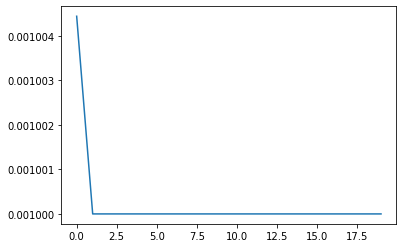

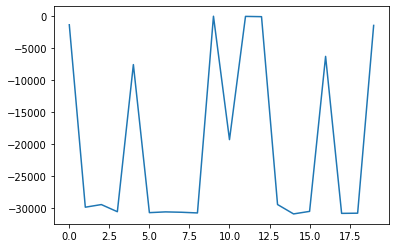

In [23]:
n_episodes = len(out.history['episode_reward'])
x_axis = range(n_episodes)
print(n_episodes)
plt.plot(x_axis, out.history['episode_average_tau'])
plt.show()
plt.plot(x_axis, out.history['episode_reward'])
plt.show()

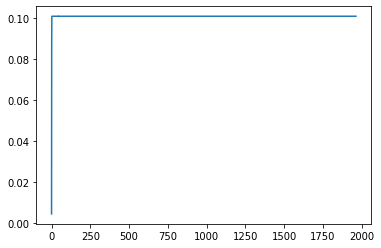

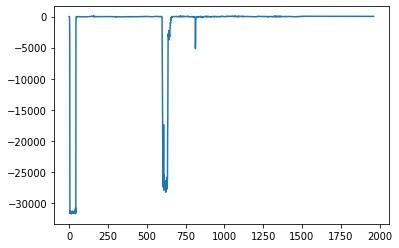

In [15]:
n_episodes = len(out.history['episode_average_tau'])
x_axis = range(n_episodes)
plt.plot(x_axis, out.history['episode_average_tau'])
plt.show()
plt.plot(x_axis, out.history['episode_reward'])
plt.show()

In [16]:
a.test(env, l=l, nb_max_episode_steps=episode_step, visualize=0)

Testing for 1 episodes ...


UnboundLocalError: local variable 'cbf' referenced before assignment

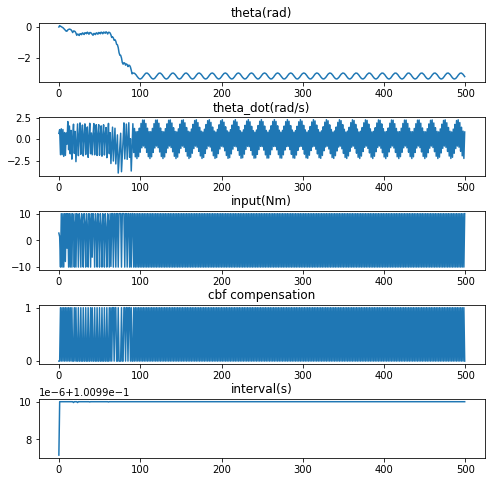

In [13]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'cbf compensation', 'interval(s)'] 
history = a.data_log[0]
x_axis = range(history.shape[0])
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(history.shape[1]):
    data = history[:,i]
    plt.subplot(history.shape[1],1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [6]:
print(out.history['episode_reward'])
observation = np.array([1.65,1])
a.forward(observation)

[0.2545098288126665, 0.2529258853115166, 0.25112259682202187, 0.25301912382581254, 0.252364068340555, 0.45092301604120333, 0.2906436879077258, 2.0687690286856086, 2.708959010967242, 2.722884273142362, 2.7071587111365782, 2.6749177980192265, 2.6706366152152534, 2.6380343698641324, 2.651115618509404, 2.441861273527565, 2.41434140116133, 2.344908014481406]


array([-9.999897,  0.011   ], dtype=float32)

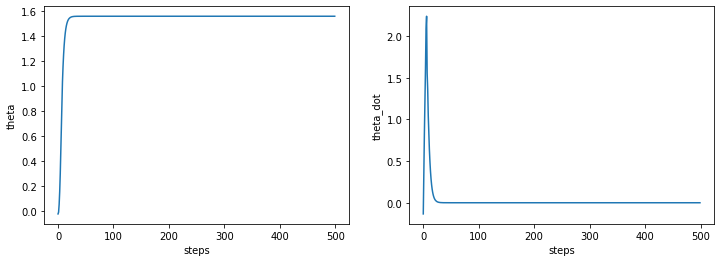

In [17]:
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
reward = 0
for i in range(500):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward += - 0.01 * a_agent**2 + l * tau
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

In [18]:
_5output = out

In [24]:
_05output = out